In [5]:
import argparse
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.utils import make_grid
import keras
from keras import datasets, layers, models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, get_scorer_names, precision_score, recall_score, f1_score
from sklearn import metrics
from PIL import Image, ImageDraw
from tqdm import tqdm
# We import the data set from tensorflow and build the model there
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

import torch
# If you do not have a GPU or do not want to run this code on your GPU, comment out the following lines
torch.cuda.empty_cache()
torch.cuda.is_available()

True

## Transfer Learning with TensorFlow Keras

https://github.com/tejanirla/image_classification/blob/master/transfer_learning.ipynb

In [15]:
train_dir = "Data/hand/new_train"
val_dir = "Data/hand/valid"
test_dir = "Data/hand/test"
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   width_shift_range = 0.02,
                                   height_shift_range = 0.02,
                                   horizontal_flip = False)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator( rescale = 1.0/255.)

# Note that the test data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 40 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 40,
                                                    class_mode = 'categorical', 
                                                    target_size = (100, 75), shuffle = True)   
# Flow validation images in batches of 40 using val_datagen generator
val_generator =  val_datagen.flow_from_directory( val_dir,
                                                          batch_size  = 40,
                                                          class_mode  = 'categorical', 
                                                          target_size = (100, 75), shuffle = True)  

# Flow test images in batches of 40 using test_datagen generator
test_generator =  test_datagen.flow_from_directory( test_dir,
                                                          batch_size  = 40,
                                                          class_mode  = 'categorical', 
                                                          target_size = (100, 75), shuffle = False)

Found 6799 images belonging to 8 classes.
Found 1713 images belonging to 8 classes.
Found 2802 images belonging to 8 classes.


In [16]:
pre_trained_model = InceptionV3(input_shape = (100, 75, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = True

In [17]:
last_layer = pre_trained_model.get_layer('mixed4') #Only use layers including and above 'mixed4'
last_op = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_op)
# # Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (8, activation='softmax')(x)           

model = keras.Model(pre_trained_model.input, x) 

model.compile(optimizer = keras.optimizers.SGD(learning_rate=0.01), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [18]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=20)
]

history = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 20,
            epochs = 200,
            validation_steps = 20,
            verbose = 2,
            callbacks=callbacks_list)

Epoch 1/200
20/20 - 27s - loss: 1.9220 - acc: 0.3300 - val_loss: 1.8394 - val_acc: 0.3562 - 27s/epoch - 1s/step
Epoch 2/200
20/20 - 26s - loss: 1.6401 - acc: 0.4137 - val_loss: 1.6308 - val_acc: 0.3825 - 26s/epoch - 1s/step
Epoch 3/200
20/20 - 25s - loss: 1.4685 - acc: 0.4837 - val_loss: 1.4922 - val_acc: 0.4663 - 25s/epoch - 1s/step
Epoch 4/200
20/20 - 26s - loss: 1.4030 - acc: 0.4837 - val_loss: 1.4417 - val_acc: 0.5250 - 26s/epoch - 1s/step
Epoch 5/200
20/20 - 26s - loss: 1.3080 - acc: 0.5362 - val_loss: 1.3914 - val_acc: 0.4625 - 26s/epoch - 1s/step
Epoch 6/200
20/20 - 26s - loss: 1.2921 - acc: 0.5425 - val_loss: 1.2891 - val_acc: 0.5525 - 26s/epoch - 1s/step
Epoch 7/200
20/20 - 26s - loss: 1.2974 - acc: 0.5400 - val_loss: 1.3057 - val_acc: 0.5300 - 26s/epoch - 1s/step
Epoch 8/200
20/20 - 27s - loss: 1.2332 - acc: 0.5738 - val_loss: 1.2015 - val_acc: 0.5938 - 27s/epoch - 1s/step
Epoch 9/200
20/20 - 26s - loss: 1.1623 - acc: 0.5813 - val_loss: 1.1520 - val_acc: 0.5938 - 26s/epoch - 

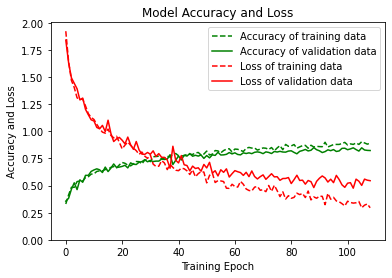

In [19]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [20]:
score = model.evaluate(test_generator, verbose=1)
print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

71/71 [==============================] - 79s 1s/step - loss: 0.5776 - acc: 0.8098

Accuracy on test data: 0.81

Loss on test data: 0.58


In [21]:
y_pred_test = model.predict(test_generator)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = test_generator.classes
precision = precision_score(max_y_test, max_y_pred_test, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(max_y_test, max_y_pred_test, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(max_y_test, max_y_pred_test, average='weighted')
print('F1 score: %f' % f1)

71/71 [==============================] - 38s 526ms/step
Precision: 0.814722
Recall: 0.809779
F1 score: 0.809832


In [22]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7]
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

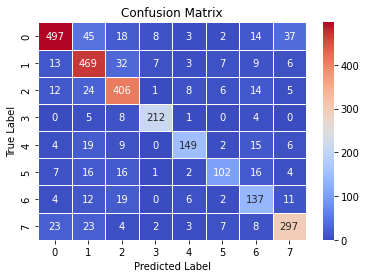


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       624
           1       0.77      0.86      0.81       546
           2       0.79      0.85      0.82       476
           3       0.92      0.92      0.92       230
           4       0.85      0.73      0.79       204
           5       0.80      0.62      0.70       164
           6       0.63      0.72      0.67       191
           7       0.81      0.81      0.81       367

    accuracy                           0.81      2802
   macro avg       0.81      0.79      0.79      2802
weighted avg       0.81      0.81      0.81      2802



In [23]:
show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [24]:
model.save("best_model_hand_molyswu.h5")

## Evaluating on Unseen Drivers

In [25]:
unseen_dir = "Data/hand/unseen"
unseen_datagen = ImageDataGenerator( rescale = 1.0/255. )

unseen_generator = unseen_datagen.flow_from_directory(unseen_dir,
                                                    batch_size = 40,
                                                    class_mode = 'categorical', 
                                                    target_size = (100, 75), shuffle = False)   

Found 526 images belonging to 8 classes.


In [26]:
model = keras.models.load_model("best_model_hand_molyswu.h5")

In [27]:
score = model.evaluate(unseen_generator, verbose=1)
print("\nAccuracy on unseen data: %0.2f" % score[1])
print("\nLoss on unseen data: %0.2f" % score[0])

14/14 [==============================] - 14s 950ms/step - loss: 1.5246 - acc: 0.5589

Accuracy on unseen data: 0.56

Loss on unseen data: 1.52


In [28]:
y_pred_test = model.predict(unseen_generator)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = unseen_generator.classes
precision = precision_score(max_y_test, max_y_pred_test, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(max_y_test, max_y_pred_test, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(max_y_test, max_y_pred_test, average='weighted')
print('F1 score: %f' % f1)

14/14 [==============================] - 6s 376ms/step
Precision: 0.512431
Recall: 0.558935
F1 score: 0.526720


In [29]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7]
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

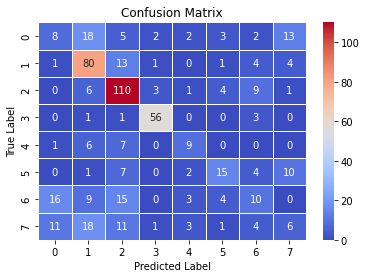


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.22      0.15      0.18        53
           1       0.58      0.77      0.66       104
           2       0.65      0.82      0.73       134
           3       0.89      0.92      0.90        61
           4       0.45      0.39      0.42        23
           5       0.54      0.38      0.45        39
           6       0.28      0.18      0.22        57
           7       0.18      0.11      0.13        55

    accuracy                           0.56       526
   macro avg       0.47      0.46      0.46       526
weighted avg       0.51      0.56      0.53       526



In [30]:
show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))